In [18]:
from cher2d.PhotoSensor import PhotoSensor
from cher2d.PhotoSensorModule import PhotoSensorModule
from cher2d.Detector import Detector
from cher2d.Emitter import Emitter
from cher2d.Analyzer import Analyzer
from cher2d.Visualizer import Visualizer

import pandas as pd
import numpy as np

## Study 1: Compare Azimov performances

Some studies:
 * look at local curvature estimates for covariance compared to repeated fits
   * for (-3000,2900,-0.6,1500) mod_n = 10, find that local curvature works better for dome than flst
   * for (-3000,3300,-0.6,1500) mod_n = 100, flat and dome are similar

In [2]:
# utility methods

def get_n_pe(event):
    n_pe = 0
    for i_module in range(len(event.n_pe)):
        for i_sensor in range(len(event.n_pe[i_module])):
            n_pe += event.n_pe[i_module][i_sensor]
    return n_pe

In [51]:
# setup design properties, build detector and emitter

photosensor_design = PhotoSensor.default_properties()
flat_mpmt_design = PhotoSensorModule.flat_mpmt_properties()
dome_mpmt_design = PhotoSensorModule.dome_mpmt_properties()
detector_design = Detector.default_properties()

# Make an EXACT detector and emitter
exact = True
flat_detector = Detector(0, detector_design, flat_mpmt_design, photosensor_design, exact=exact)
dome_detector = Detector(1, detector_design, dome_mpmt_design, photosensor_design, exact=exact)

emitter_design = Emitter.default_properties()
emitter_design['x'].mean = -3000.
emitter_design['y'].mean = 3300.
emitter_design['length'].mean = 1500.
# change the brightness below (at 3, draw every 100 photons)
mod_n = 100
emitter_design['ch_density'].mean = 0.03 * mod_n
my_emitter = Emitter(0, emitter_design, exact=exact)
t_0 = 2.

# this is how to apply a systematic offset:
#my_emitter.set_offset('x',15.)

Expected number of photons: 4500.0 | Expected number of pe: 1536.6
DETECTOR TYPE: dome
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -5727                      │              Nfcn = 114              │
│ EDM = 2.39e-16 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Er

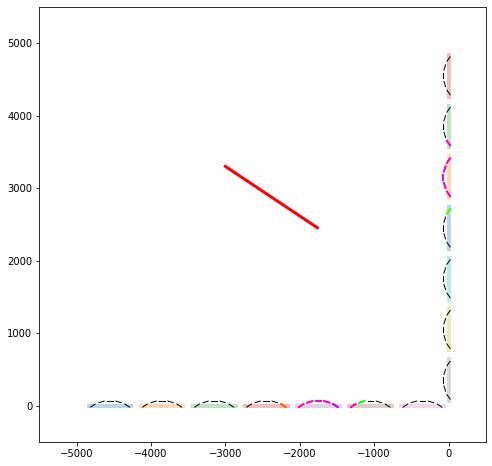

In [55]:
# do analysis
detector_type = 'dome'

detector = flat_detector
if detector_type == 'dome':
    detector = dome_detector

my_vis = Visualizer(detector)
my_vis.draw_detector()   

event_type = 'azimov'

if event_type == 'normal':
    my_emitter.emit(t_0)
    my_vis.draw_photons(my_emitter, mod_n=mod_n)
    my_event = detector.get_event(my_emitter)
else:
    # Asimov event
    true_parameters = {}
    for par_name in ['x', 'y', 'angle', 'length']:
        true_parameters[par_name] = my_emitter.get_value(par_name, True)
    true_parameters['t0'] = t_0
    my_event = detector.get_asimov(my_emitter, true_parameters, True)

my_vis.draw_emitter(my_emitter)
my_vis.draw_event(my_event)
my_vis.show()

if event_type == 'normal':
    print('Number of photons:',len(my_emitter.photons),'. Number of pe:',get_n_pe(my_event))
else:
    n_exp = my_emitter.get_value('ch_density',True)*my_emitter.get_value('length',True)
    print('Expected number of photons: {0:0.1f} | Expected number of pe: {1:0.1f}'.format(n_exp,get_n_pe(my_event)))

if 1 == 1:
    print('===========')
    print('DETECTOR TYPE:',detector_type)
    print('===========')
    my_analyzer = Analyzer(detector, my_emitter)

    # guess for parameters
    parameters = {}
    parameters['x'] = my_emitter.design_properties['x'].mean
    parameters['y'] = my_emitter.design_properties['y'].mean
    parameters['angle'] = my_emitter.design_properties['angle'].mean
    parameters['length'] = my_emitter.design_properties['length'].mean
    parameters['t0'] = t_0

    m = my_analyzer.get_minuit(my_event, parameters)

    m.migrad()  # run optimiser
    # print(m.values)

    print(m.hesse())  # run covariance estimator
    # print(m.errors)

    truth = []
    truth.append(my_emitter.true_properties['x'].get_value())
    truth.append(my_emitter.true_properties['y'].get_value())
    truth.append(my_emitter.true_properties['angle'].get_value())
    truth.append(my_emitter.true_properties['length'].get_value())
    truth.append(t_0)

    print('Minimum valid:', m.valid, '  Covariance is accurate:', m.accurate)

    for p, v, e, t in zip(m.parameters, m.values, m.errors, truth):
        print(f"{p} = {v:.3f} +/- {e:.3f} | {t:.3f}")

    print(m.covariance.correlation())

In [9]:
mpmt = flat_detector.photo_sensor_modules[0]
#mpmt = my_dome_detector.photo_sensor_modules[0]
pmt = mpmt.photo_sensors[0]
for device in [detector, mpmt, pmt, my_emitter]:
    print('')
    print(device.__class__.__name__,device.device_id,'properties')
    print('+++++++++++++++++++++++++++++++++++')
    print(device.get_table())


Detector 1 properties
+++++++++++++++++++++++++++++++++++
Property         Description                                              Type    Dist.   Mean    Sigma   Offset   Truth
readout_window   time window for event readout (about the mean time of    float   exact   50      0       0        50   
                 signals) (ns)                                                                                          
------------------------------------------------------------------------------------------------------------------------
n_module         number of photosensor modules in detector                int     exact   14      0       0        14   
------------------------------------------------------------------------------------------------------------------------
pitch            separation between centres of photosensor modules (mm)   float   exact   700     0       0        700  
----------------------------------------------------------------------------------------------

In [29]:
# do many repetitions of normal events
n_event = 20

detector_type = 'flat'

detector = flat_detector
if detector_type == 'dome':
    detector = dome_detector

print('===========')
print('DETECTOR TYPE:',detector_type)
print('===========')

my_analyzer = Analyzer(detector, my_emitter)

# guess for parameters
parameters = {}
parameters['x'] = my_emitter.design_properties['x'].mean
parameters['y'] = my_emitter.design_properties['y'].mean
parameters['angle'] = my_emitter.design_properties['angle'].mean
parameters['length'] = my_emitter.design_properties['length'].mean
parameters['t0'] = t_0

results = []

for i in range(n_event):    

    my_emitter.emit(t_0)
    my_event = detector.get_event(my_emitter)

    if 1 == 1:

        m = my_analyzer.get_minuit(my_event, parameters)

        m.migrad()  # run optimiser
        # print(m.values)

        m.hesse()  # run covariance estimator
        # print(m.errors)

        truth = []
        truth.append(my_emitter.true_properties['x'].get_value())
        truth.append(my_emitter.true_properties['y'].get_value())
        truth.append(my_emitter.true_properties['angle'].get_value())
        truth.append(my_emitter.true_properties['length'].get_value())
        truth.append(t_0)

        print('Minimum valid:', m.valid, '  Covariance is accurate:', m.accurate)

        result = {}
        do_print = (i%10 == 0)
        
        for p, v, e, t in zip(m.parameters, m.values, m.errors, truth):
            if do_print:
                print(f"{p} = {v:.3f} +/- {e:.3f} | {t:.3f}")
            result[p] = v

        if do_print:
            print(m.covariance.correlation())
        
        result['min valid'] = m.valid
        result['cov accurate'] = m.accurate
        
        results.append(result)

DETECTOR TYPE: flat
Minimum valid: True   Covariance is accurate: False
x = -3008.133 +/- 169.488 | -3000.000
y = 2845.887 +/- 14.708 | 2900.000
angle = -0.584 +/- 0.005 | -0.600
length = 1478.272 +/- 11.650 | 1500.000
t0 = 1.949 +/- 0.183 | 2.000
┌────────┬────────────────────────────────────┐
│        │      x      y  angle length     t0 │
├────────┼────────────────────────────────────┤
│      x │      1  0.997  0.996  0.992  0.938 │
│      y │  0.997      1  0.993  0.992  0.935 │
│  angle │  0.996  0.993      1  0.991  0.934 │
│ length │  0.992  0.992  0.991      1   0.93 │
│     t0 │  0.938  0.935  0.934   0.93      1 │
└────────┴────────────────────────────────────┘
Minimum valid: True   Covariance is accurate: True
Minimum valid: True   Covariance is accurate: True
Minimum valid: True   Covariance is accurate: False
Minimum valid: True   Covariance is accurate: True
Minimum valid: True   Covariance is accurate: True
Minimum valid: True   Covariance is accurate: True
Minimum valid

In [44]:
ddf = pd.DataFrame(dome_results)
fdf = pd.DataFrame(flat_results)

In [48]:
np.std(ddf['y'].values)

41.26079664185662

In [37]:
df.corr()

,x,y,angle,length,t0,min valid,cov accurate
x,1.000000,0.826413,-0.829580,0.490826,0.035777,NaN,-0.435339
y,0.826413,1.000000,-0.895006,0.632437,-0.113570,NaN,-0.275894
angle,-0.829580,-0.895006,1.000000,-0.483986,-0.063415,NaN,0.161906
length,0.490826,0.632437,-0.483986,1.000000,-0.237402,NaN,-0.538778
t0,0.035777,-0.113570,-0.063415,-0.237402,1.000000,NaN,0.128610
min valid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cov accurate,-0.435339,-0.275894,0.161906,-0.538778,0.128610,NaN,1.000000


In [40]:
import pickle
with open('flat.pkl', 'wb') as f:
    pickle.dump(results, f)

In [41]:
with open('dome.pkl', 'rb') as f:
    dome_results = pickle.load(f)
with open('flat.pkl', 'rb') as f:
    flat_results = pickle.load(f)